# Week 3 Assignment
## Kaggle: Histopathologic Cancer Detection

By: Austin Jenkins

Class: CSCA 5642 - Introduction to Deep Learning

Github Repository: https://github.com/ajenkins198621/csca-5642-module3-histopathologic-cancer-detection

### I. Introduction

#### The Problem

As defined in the Kaggle competition page, the problem is to identify the metastic tissue in histopathologic scans of lymph node sections.  We are provided small image patches taken from larger digital pathology scans.  

#### The Data

I used the ```kaggle competitions download -c histopathologic-cancer-detection``` command to download the ~6.3GB of data.

### II. EDA - Exploratory Data Analysis

Alright, so now that I've downloaded the data, let's take a look to see what we're working with.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
import keras
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import (Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom)
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import os
from PIL import Image



plt.style.use('dark_background')
cancer_color = "#A31621"
non_cancer_color = "#1F7A8C"

In [2]:
train_labels_path = "histopathologic-cancer-detection/train_labels.csv"
train_images_path = "histopathologic-cancer-detection/train"

labels = pd.read_csv(train_labels_path)
print("Dataset Overview:")
print(labels.head())
print("--------------------")

print("Label Distribution:")
print(labels['label'].value_counts())


Dataset Overview:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
--------------------
Label Distribution:
label
0    130908
1     89117
Name: count, dtype: int64


Here we can see the dataset, which has id and label columns.  The id refers to an image in the ```/histopathologic-cancer-detection/train``` directory.  The label is a binary value, 0 for non-cancerous and 1 for cancerous.

As we can see, there are 130,908 non-cancerous images and 89,117 cancerous images.  Let's take a look at this in a graph.

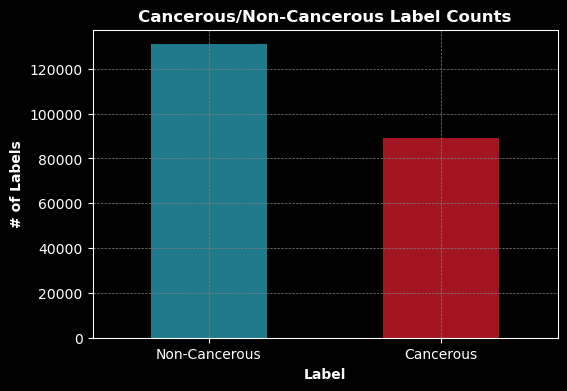

In [3]:
labels['label'].value_counts().plot(kind='bar', color=[non_cancer_color, cancer_color], figsize=(6, 4))
plt.title("Cancerous/Non-Cancerous Label Counts", fontweight='bold')
plt.xlabel("Label", fontweight='bold')
plt.ylabel("# of Labels", fontweight='bold')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'], rotation=0)
plt.grid(True, linewidth=0.5, color='gray', linestyle='--')

plt.show()

That's great, but because the dataset is quite large, I think it might be easier to see the distribution in a pie chart.

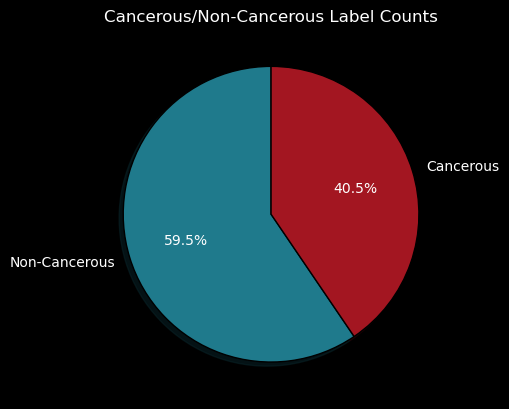

In [4]:
counts = labels['label'].value_counts()


plt.pie(counts,labels=["Non-Cancerous", "Cancerous"], colors=[non_cancer_color, cancer_color], shadow=True, startangle=90, autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'})

plt.title("Cancerous/Non-Cancerous Label Counts")
plt.show()

Great, so now we can see that the Non-Cancerous images account for 59.5% of the dataset, while the Cancerous images account for 40.5% of the dataset.

Now let's take a look at a subset of these images so we can see what they actually look like.

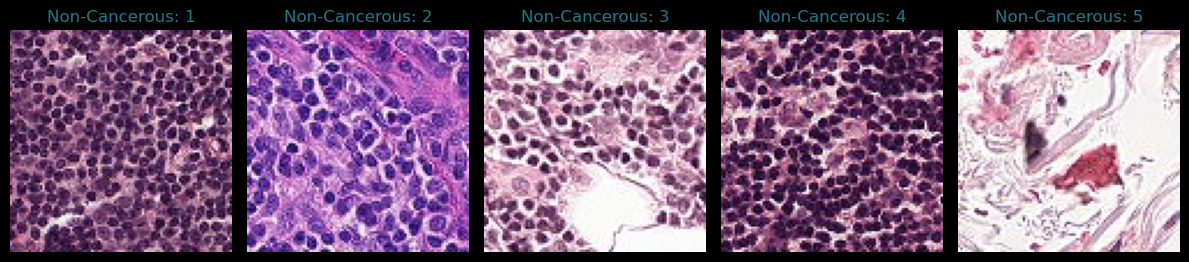

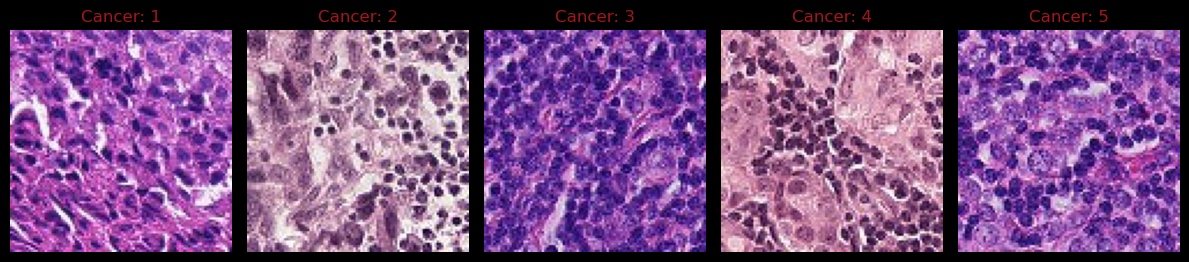

In [5]:
def plot_images(data, display_label, title_color):
    paths = [os.path.join(train_images_path, f"{id}.tif") for id in data['id']]

    _, axes = plt.subplots(1, 5, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(5):
        img = cv2.imread(paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(f"{display_label}: {i + 1}", color=title_color)
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

non_cancerous_data = labels[labels['label'] == 0].sample(5)
plot_images(data=non_cancerous_data, display_label="Non-Cancerous", title_color=non_cancer_color)

cancerous_data = labels[labels['label'] == 1].sample(5)
plot_images(data=cancerous_data, display_label="Cancer", title_color=cancer_color)


<strong>Data Cleanup</strong>

Now let's check to see if there's any cleaning of the data we can do.  The only obvious thing I can think of is to check for any missing or duplicate values.

In [6]:
duplicate_labels = labels[labels.duplicated(keep=False)]
print("Duplicate Labels:")
print(duplicate_labels)

Duplicate Labels:
Empty DataFrame
Columns: [id, label]
Index: []


As we can see by the empty dataframe, there aren't any duplicate values in the dataset.  Let's check for missing values.

In [7]:
missing_labels = labels[labels.isnull().any(axis=1)]
print("Missing Labels:")
print(missing_labels)

Missing Labels:
Empty DataFrame
Columns: [id, label]
Index: []


We don't have any missing values either.  So it looks like we're good to go with the data we have.

### III. Model Architecture

#### About my architecture:

##### Layers:

<strong>Input Layer:</strong>

96x96 pixels, RGB images

<string>Convolutional Layers:</strong>

- Conv2D: 16 filters in the 1st block, 32 in the 2nd, and 64 in the 3rd. Kernel size: (3, 3).  Activation function: ReLU
- BatchNormalization: Normalizes the activations, helping stabilize and speed up training.
- MaxPooling2D: Pool size: (2, 2) for down-sampling the feature maps.
- Dropout: Prevents overfitting by randomly setting a fraction of weights to zero. Dropout rates: 0.1 for the first two blocks, 0.3 for the third block.

<strong>Fully Connected Layers:</strong>

- Flatten: Converts the 2D feature maps to a 1D vector for the dense layers.
- Dense Layer: 256 units with ReLU activation. Regularization via Dropout with a rate of 0.5.
- Output Layer: A single unit with a sigmoid activation function for binary classification.

##### Hyperparameters:

<strong>Training Hyperparameters:</strong>

- Optimizer: RMSProp
- Learning Rate: 0.001.
- Number of Epochs: 10.

<strong>Model Hyperparameters:</strong>

- Kernel Size: (3, 3) for all Conv2D layers.
- Filters: 16, 32, 64 filters in successive convolutional blocks.
- Dropout Rates: 0.1 for the first two blocks, 0.3 for the third block, and 0.5 for the dense layer.
- Activation Functions: ReLU for intermediate layers. Sigmoid for the output layer.

##### Optimization:
- Loss Function: Binary Crossentropy
- Early Stopping: 2 patience - Stops the training to prevent overfitting (and saves time running on my Macbook!)

##### Regularization:
- Dropout: Used in the convolutional and dense layers to prevent overfitting.
- Batch Normalization: Normalizes the activations, helping stabilize and speed up training.

First things first, I'll split the data into training and validation sets.  I'll use 80% of the data for training and 20% for validation.

In [8]:
train_df, val_df = train_test_split(labels, test_size=0.2, random_state=101, stratify=labels['label'])

Next, we need to separate the images into two separate directries, one for cancerous images and one for non-cancerous images.  This will make it easier to work with the data.

In [9]:
base_tile_dir = train_images_path
train_dir = 'histopathologic-cancer-detection/train_data'
val_dir = 'histopathologic-cancer-detection/val_data'
labels_csv_path = train_labels_path

for fold in [train_dir, val_dir]:
    for label in ['0', '1']:
        os.makedirs(os.path.join(fold, label), exist_ok=True)

def move_images(dataframe, destination_dir):
    for _, row in dataframe.iterrows():
        fname = f"{row['id']}.tif"
        label = str(row['label'])
        src = os.path.join(base_tile_dir, fname)
        dst = os.path.join(destination_dir, label, fname)
        if os.path.exists(src):
            shutil.copyfile(src, dst)

def is_directory_empty(directory):
    return all(
        not os.listdir(os.path.join(directory, label)) 
        for label in ['0', '1']
    )

if is_directory_empty(train_dir):
    move_images(train_df, train_dir)

if is_directory_empty(val_dir):
    move_images(val_df, val_dir)


Next, I'll go ahead and load the images and create some datasets that we can work with.

In [10]:
image_size = (96, 96)
batch_size = 32
train_dir = 'histopathologic-cancer-detection/train_data'
val_dir = 'histopathologic-cancer-detection/val_data'


def load_image(file_path, label):
    file_path = file_path.numpy().decode("utf-8")
    with Image.open(file_path) as img:
        img = img.convert("RGB")
        img = img.resize(image_size)
        img = np.array(img) / 255.0

    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    img_tensor.set_shape((image_size[0], image_size[1], 3))
    label_tensor = tf.convert_to_tensor(label, dtype=tf.int32)
    return img_tensor, label_tensor


def create_dataset(dataframe, base_dir):
    file_paths = [os.path.join(base_dir, f"{row['id']}.tif") for _, row in dataframe.iterrows()]
    labels = dataframe['label'].astype(np.int32).values

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    def process_path(file_path, label):
        img, lbl = tf.py_function(func=load_image, inp=[file_path, label], Tout=(tf.float32, tf.int32))
        img.set_shape((image_size[0], image_size[1], 3))
        lbl.set_shape([])
        return img, lbl

    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_df, base_tile_dir)
val_dataset = create_dataset(val_df, base_tile_dir)

Now we'll add some augmentation to the images to help with training.

In [11]:
data_augmentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Alright, now we can get to training the model!

In [12]:
layer_activation_function = 'relu'
output_activation_function = 'sigmoid'
loss_function = 'binary_crossentropy'
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model = Sequential([
    Conv2D(16, (3, 3), activation=layer_activation_function, input_shape=(96, 96, 3)),
    BatchNormalization(),
    Conv2D(16, (3, 3), activation=layer_activation_function),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(32, (3, 3), activation=layer_activation_function),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation=layer_activation_function),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(64, (3, 3), activation=layer_activation_function),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation=layer_activation_function),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation=layer_activation_function),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation=output_activation_function)
])

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now we can train the model!

In [ ]:
subset_train = train_df.sample(frac=0.1, random_state=42)  # Use 10% of the data
subset_val = val_df.sample(frac=0.1, random_state=42)
train_dataset = create_dataset(subset_train, base_tile_dir)
train_dataset = train_dataset.cache()
val_dataset = create_dataset(subset_val, base_tile_dir)


steps_per_epoch = int(np.ceil(len(train_df) / batch_size))
validation_steps = int(np.ceil(len(val_df) / batch_size))
number_of_epochs = 10

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=number_of_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)


Epoch 1/10
 550/5501 ━━━━━━━━━━━━━━━━━━━━ 7:51 95ms/step - accuracy: 0.8784 - loss: 0.3004

/opt/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.8794 - loss: 0.2953 - val_accuracy: 0.8466 - val_loss: 0.3672
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.8841 - loss: 0.2824 - val_accuracy: 0.7448 - val_loss: 0.9028
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.8862 - loss: 0.2784 - val_accuracy: 0.8639 - val_loss: 0.3053
Epoch 4/10
   2/5501 ━━━━━━━━━━━━━━━━━━━━ 8:34 94ms/step - accuracy: 0.9297 - loss: 0.3243

2025-01-26 10:14:14.511359: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.8874 - loss: 0.2741 - val_accuracy: 0.7552 - val_loss: 0.7562
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.8893 - loss: 0.2672 - val_accuracy: 0.8477 - val_loss: 0.4063


### Results and Analysis

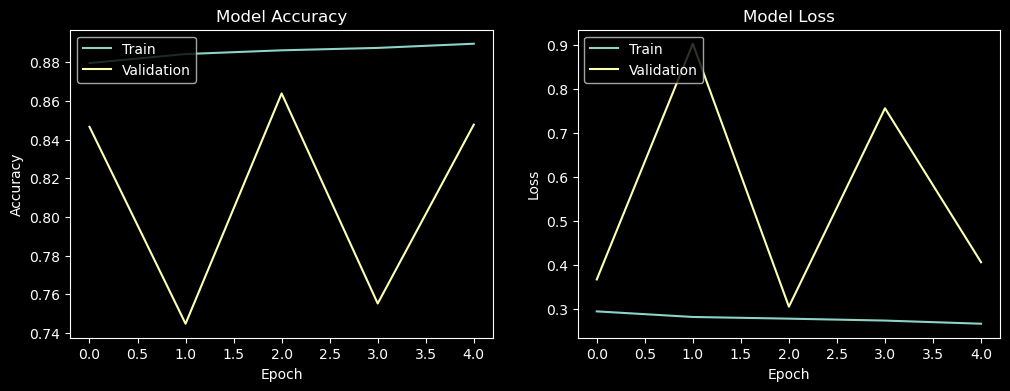

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Finally, let's create a submission so we can see how this model performs on the test data provided by Kaggle.  We'll submit this to the Kaggle competition and see where it lands on the leaderboard.

In [18]:
test_dir = 'histopathologic-cancer-detection/test'
test_image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.tif')]

def preprocess_test_image(file_path):
    file_path = file_path.numpy().decode("utf-8")
    with Image.open(file_path) as img:
        img = img.convert("RGB") 
        img = img.resize(image_size)
        img = np.array(img) / 255.0
    return tf.convert_to_tensor(img, dtype=tf.float32)

def create_test_dataset(image_paths, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    def process_path(file_path):
        return tf.py_function(preprocess_test_image, inp=[file_path], Tout=tf.float32)
    
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

test_dataset = create_test_dataset(test_image_paths, batch_size=32)

predictions = model.predict(test_dataset, verbose=0)

binary_predictions = (predictions.flatten() > 0.5).astype(int)
test_image_ids = [os.path.basename(path).split('.')[0] for path in test_image_paths]
submission = pd.DataFrame({'id': test_image_ids, 'label': binary_predictions})
submission.to_csv('submission.csv', index=False)


#### Hyperparmeter Tuning

I tried a few different hyperparameters to see if I could improve the model's performance.  Below was my strategy:

##### Attempt 1:
- Use higher filters for each of the convolution layers.
- Use a 0.005 learning rate.
- Use 5 epochs.
- Use the Adam optimizer.
- Use a subset of the data for training and validation.

The final result of my first attempt was a public score of <strong>0.7481</strong> on the Kaggle leaderboard. This was a good starting point, but I think I can do better.  The reason I think I can do better is because I only used a subset of the data for training and validation.  I think if I use the entire dataset, I can get a better result.

##### Attempt 2:
- Use higher filters for each of the convolution layers.
- Use a 0.001 learning rate.
- Use 10 epochs.
- Continue using the Adam optimizer.
- Use full data set

The final result of my second attempt was a public score of <strong>0.8067</strong> on the Kaggle leaderboard.  This was a decent improvement over my first attempt.  I think I can do better, so I'll try one more time. In this next attempt I tried using RMSPROP as the optimizer.

##### Attempt 3:
- RMSprop optimizer.
- Learning rate of 0.0001.

##### Attempt 4:
- Adam optimizer, because it performed better than RMSprop.
- Using a 10% subset of the data

The result for #4 was a public score of <strong>0.8574</strong> on the Kaggle leaderboard.  This was the best score I was able to achieve, so I will use this model for the final submission.

I ultimately prefered the Attempt 4 model (which was just same Attempt #2 with a subset), as it performed better on the Kaggle leaderboard for the private score, so that is the model I will use for the final submission.  Below you can see the Kaggle results of the different attempts.


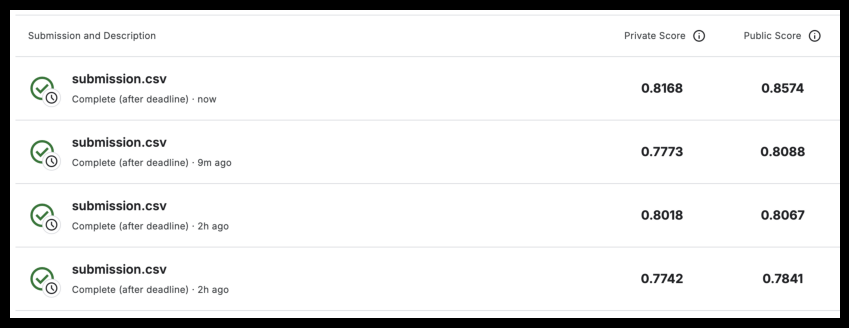

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("screenshots/submissions_screenshot.png")

plt.figure(figsize=(12, 4))
plt.imshow(image)
plt.axis('off')
plt.show()


Of course, this competition is long over.  However, my final submission was a public score of <strong>0.8574</strong> and a private score of <strong>0.8574</strong> would have landed in this area on the leaderboard.  Clearly, with a rank of 919, there is quite a bit of room for improvement.  I think with more time and resources, I could have improved this model to get a better score.

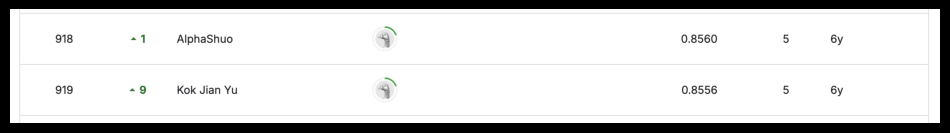

In [25]:
image = mpimg.imread("screenshots/leaderboard_screenshot.png")

plt.figure(figsize=(12, 4))
plt.imshow(image)
plt.axis('off')
plt.show()


### Conclusion

Some of the elements that had a significant impact on the model's performance were the number of filters in the convolutional layers, the learning rate, and the optimizer.  I think if I had more time to experiment with these hyperparameters, I could have improved the model's performance.

Some of the elements that did not have a significant impact on the model's performance were the number of epochs and the batch size.  I think these elements are important, but I think they are less important than the other hyperparameters I mentioned.  This is surprising to me, but likely due to the fact that I was using Early Stopping with a patience of 2 and had the limitation of running on my Macbook.

Overall, I think I did reasonably well on the Kaggle leaderboard.  I think I could have done better if I had more time to experiment with different hyperparameters.  I think I could have also done better if I had access to a GPU.  I think the model I created is a good starting point, but I think there's a lot of room for improvement.

### References
- https://keras.io/
- https://www.tensorflow.org/
- https://pillow.readthedocs.io/en/stable/reference/Image.html
- https://www.kaggle.com/code/mattison/cancer-cnn-detection
- https://www.kaggle.com/code/akarshu121/cancer-detection-with-cnn-for-beginners